In [1]:
# Common libraries for data cleaning and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import load # use to load an npz file
from scipy.signal import periodogram # use to graph a periodogram to get seasonality analysis
from sklearn.preprocessing import MinMaxScaler # use to normalize the data features

# keras library to create NN models
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# libraries for the metrics we will use (RMSE and Spearman)
from keras.metrics import RootMeanSquaredError
import scipy.stats as stats

2025-05-15 08:38:32.102960: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747316312.114340 3391064 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747316312.117771 3391064 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747316312.128130 3391064 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747316312.128139 3391064 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747316312.128141 3391064 computation_placer.cc:177] computation placer alr

In [2]:
plt.rcParams.update({'font.size': 12, 'font.family': 'serif'})
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.which'] = 'both'
plt.rcParams['grid.alpha'] = 0.5

In [3]:
data = load('pems08/PEMS08.npz')

In [4]:
lst = data.files
print(data[lst[0]].shape)
print(data[lst[0]])

(17856, 170, 3)
[[[1.330e+02 6.030e-02 6.580e+01]
  [2.100e+02 5.890e-02 6.960e+01]
  [1.240e+02 3.580e-02 6.580e+01]
  ...
  [7.400e+01 2.131e-01 6.530e+01]
  [9.400e+01 2.260e-02 6.800e+01]
  [6.000e+00 3.100e-03 6.500e+01]]

 [[1.140e+02 5.320e-02 6.690e+01]
  [1.850e+02 5.500e-02 6.850e+01]
  [1.190e+02 3.390e-02 6.500e+01]
  ...
  [7.300e+01 1.469e-01 3.720e+01]
  [8.400e+01 1.890e-02 6.870e+01]
  [4.000e+00 1.800e-03 6.500e+01]]

 [[1.400e+02 6.220e-02 6.680e+01]
  [1.710e+02 4.660e-02 6.990e+01]
  [1.070e+02 3.360e-02 6.380e+01]
  ...
  [7.000e+01 5.860e-02 3.400e+01]
  [8.200e+01 2.200e-02 6.700e+01]
  [4.000e+00 2.100e-03 6.490e+01]]

 ...

 [[1.200e+02 5.810e-02 6.330e+01]
  [1.760e+02 5.290e-02 6.680e+01]
  [1.190e+02 5.180e-02 5.610e+01]
  ...
  [4.700e+01 1.551e-01 3.220e+01]
  [9.100e+01 2.290e-02 6.640e+01]
  [3.000e+00 1.400e-03 6.530e+01]]

 [[1.020e+02 5.790e-02 6.140e+01]
  [1.650e+02 4.920e-02 6.720e+01]
  [1.330e+02 5.070e-02 5.890e+01]
  ...
  [9.700e+01 1.265e-01

In [5]:
traffic_data = data[lst[0]]
data_dict = []
# loop for every timestep and every location and add as a single row
for timestep in range(traffic_data.shape[0]):
    for location in range(traffic_data.shape[1]):
        data_dict.append({
            "timestep" : timestep+1,
            "location" : location,
            "flow"     : traffic_data[timestep][location][0],
            "occupancy"   : traffic_data[timestep][location][1],
            "speed"    : traffic_data[timestep][location][2]
        })

In [6]:
df = pd.DataFrame(data_dict)
df.to_csv("pems08/traffic08.csv", index=False)

In [7]:
df.head()

,timestep,location,flow,occupancy,speed
0,1,0,133.0,0.0603,65.8
1,1,1,210.0,0.0589,69.6
2,1,2,124.0,0.0358,65.8
3,1,3,145.0,0.0416,69.6
4,1,4,206.0,0.0493,69.4


In [8]:
traffic = pd.read_csv("pems08/traffic08.csv")
print(len(traffic))
traffic.head()

3035520


,timestep,location,flow,occupancy,speed
0,1,0,133.0,0.0603,65.8
1,1,1,210.0,0.0589,69.6
2,1,2,124.0,0.0358,65.8
3,1,3,145.0,0.0416,69.6
4,1,4,206.0,0.0493,69.4


In [9]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3035520 entries, 0 to 3035519
Data columns (total 5 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestep   int64  
 1   location   int64  
 2   flow       float64
 3   occupancy  float64
 4   speed      float64
dtypes: float64(3), int64(2)
memory usage: 115.8 MB


In [10]:
traffic.count()

timestep     3035520
location     3035520
flow         3035520
occupancy    3035520
speed        3035520
dtype: int64

In [11]:
traffic.isna().sum()

timestep     0
location     0
flow         0
occupancy    0
speed        0
dtype: int64

In [12]:
traffic.describe()

,timestep,location,flow,occupancy,speed
count,3.035520e+06,3.035520e+06,3.035520e+06,3.035520e+06,3.035520e+06
mean,8.928500e+03,8.450000e+01,2.306807e+02,6.507109e-02,6.376300e+01
std,5.154584e+03,4.907393e+01,1.462170e+02,4.590215e-02,6.652010e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,4.464750e+03,4.200000e+01,1.100000e+02,3.570000e-02,6.260000e+01
50%,8.928500e+03,8.450000e+01,2.150000e+02,6.010000e-02,6.490000e+01
75%,1.339225e+04,1.270000e+02,3.340000e+02,8.390000e-02,6.740000e+01
max,1.785600e+04,1.690000e+02,1.147000e+03,8.955000e-01,8.230000e+01


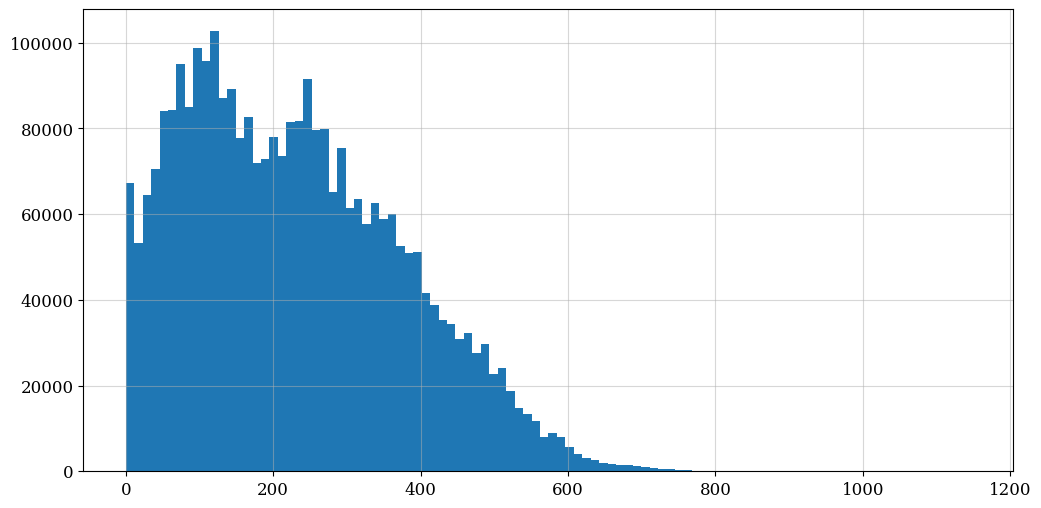

In [13]:
traffic['flow'].hist(bins=100);

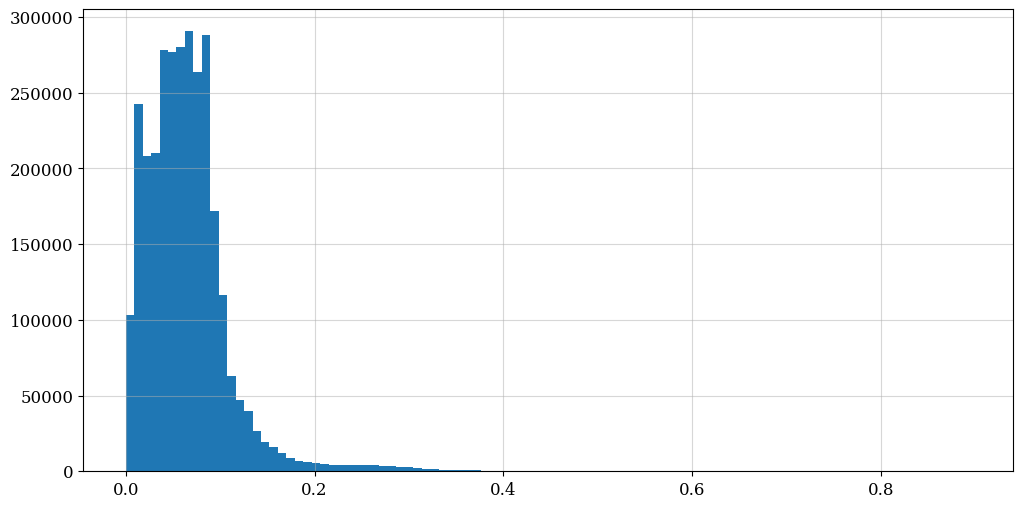

In [14]:
traffic['occupancy'].hist(bins=100);

<Axes: >

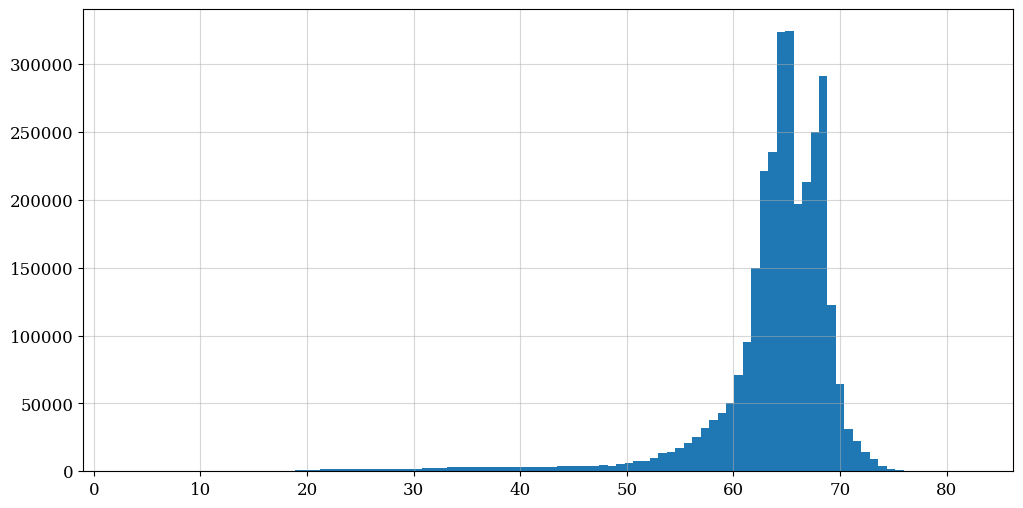

In [15]:
traffic['speed'].hist(bins=100)

In [16]:
location_0 = traffic[traffic["location"]==50].reset_index()
location_0.head()

,index,timestep,location,flow,occupancy,speed
0,50,1,50,76.0,0.0262,69.5
1,220,2,50,81.0,0.0255,68.8
2,390,3,50,80.0,0.0243,69.0
3,560,4,50,76.0,0.0255,68.4
4,730,5,50,70.0,0.0224,68.1


<Axes: >

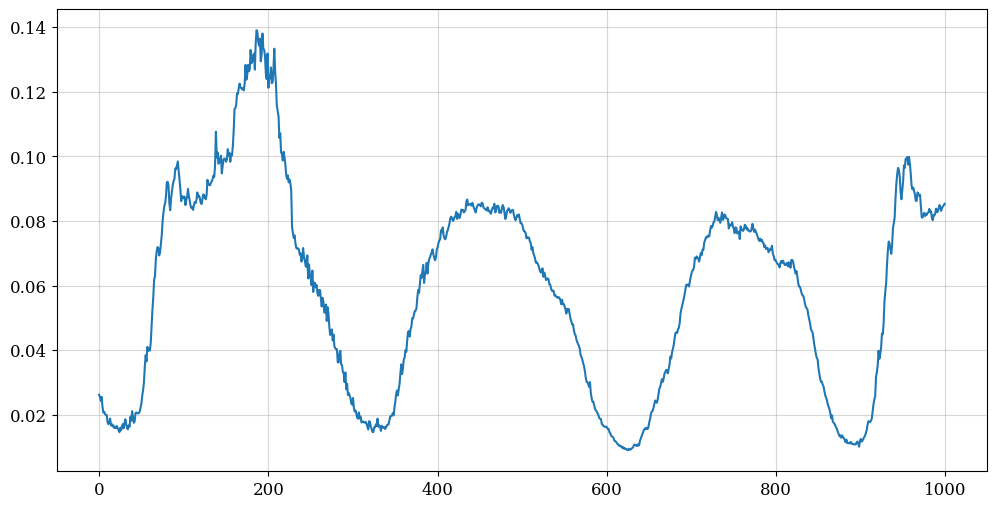

In [17]:
location_0["occupancy"][:1000].plot() 

<Axes: >

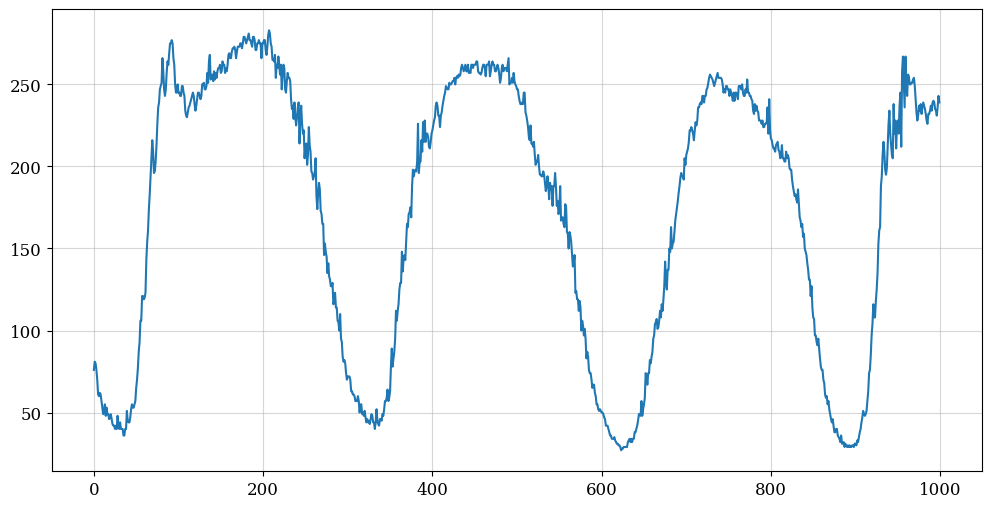

In [18]:
location_0["flow"][:1000].plot()

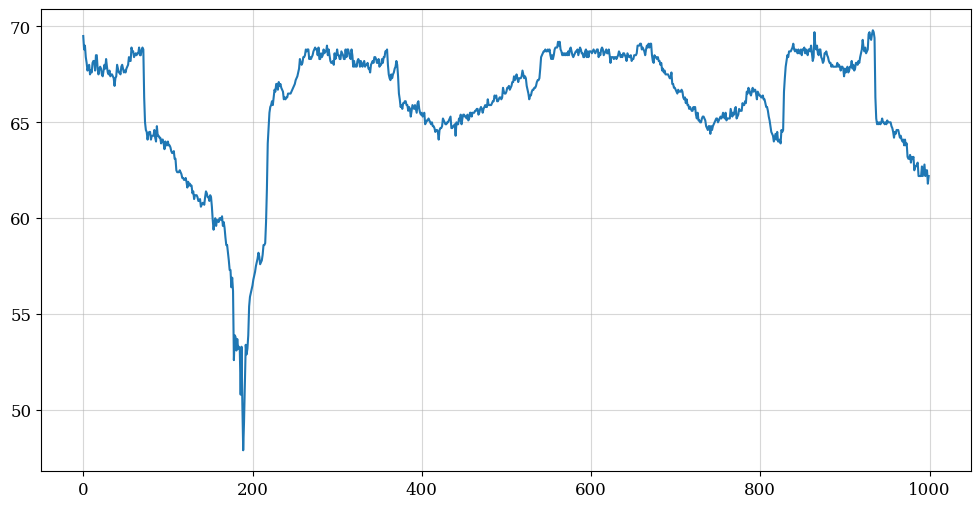

In [19]:
location_0["speed"][:1000].plot();


In [20]:
COR_STEP = 1
pres = traffic[['flow', 'occupancy', 'speed']][0:-(COR_STEP)].reset_index(drop=True)
future = traffic[['flow', 'occupancy', 'speed']][COR_STEP:] \
    .reset_index(drop=True) \
    .add_suffix('_future')
val = pres.join(future)
val.corr()

,flow,occupancy,speed,flow_future,occupancy_future,speed_future
flow,1.000000,0.674039,-0.296332,0.535235,0.450192,-0.235030
occupancy,0.674039,1.000000,-0.752040,0.445282,0.477379,-0.303858
speed,-0.296332,-0.752040,1.000000,-0.228266,-0.275180,0.233537
flow_future,0.535235,0.445282,-0.228266,1.000000,0.674040,-0.296331
occupancy_future,0.450192,0.477379,-0.275180,0.674040,1.000000,-0.752040
speed_future,-0.235030,-0.303858,0.233537,-0.296331,-0.752040,1.000000


<Axes: title={'center': 'Periodogram'}, ylabel='Variance'>

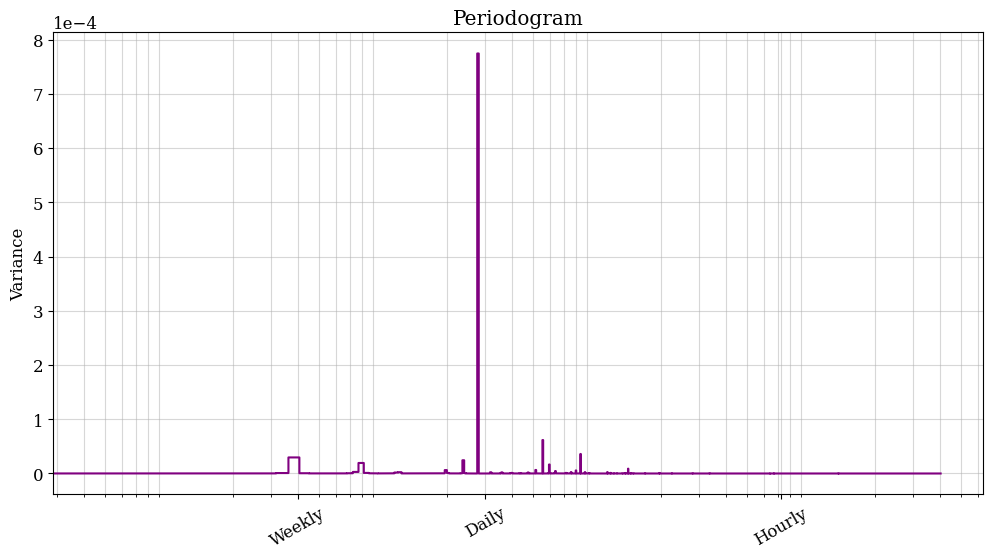

In [21]:
def plot_periodogram(ts, detrend='linear', ax=None):
    """
    Plots the periodogram of a time series.

    Args:
        ts (pd.Series): A time series.
        detrend (str): Detrending method for the time series.
        ax (matplotlib.axes.Axes): The axes on which to plot.

    Returns:
        ax (matplotlib.axes.Axes): The axes on which the periodogram is plotted.
    """
    fs = pd.Timedelta(weeks=4) / pd.Timedelta(minutes=5)
    frequencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
        
    ax.step(frequencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([4, 30, 30*24])
    ax.set_xticklabels(
        [
            "Weekly",
            "Daily",
            "Hourly"
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

plot_periodogram(location_0["occupancy"])

In [22]:
location_0["hour"] = ((location_0["timestep"] - 1) // 12)
grouped = location_0.groupby("hour").mean().reset_index()
grouped.head()

,hour,index,timestep,location,flow,occupancy,speed
0,0,985.0,6.5,50.0,65.500000,0.021700,68.191667
1,1,3025.0,18.5,50.0,48.166667,0.016567,67.900000
2,2,5065.0,30.5,50.0,41.166667,0.016350,67.691667
3,3,7105.0,42.5,50.0,46.666667,0.019350,67.591667
4,4,9145.0,54.5,50.0,89.750000,0.031800,68.141667


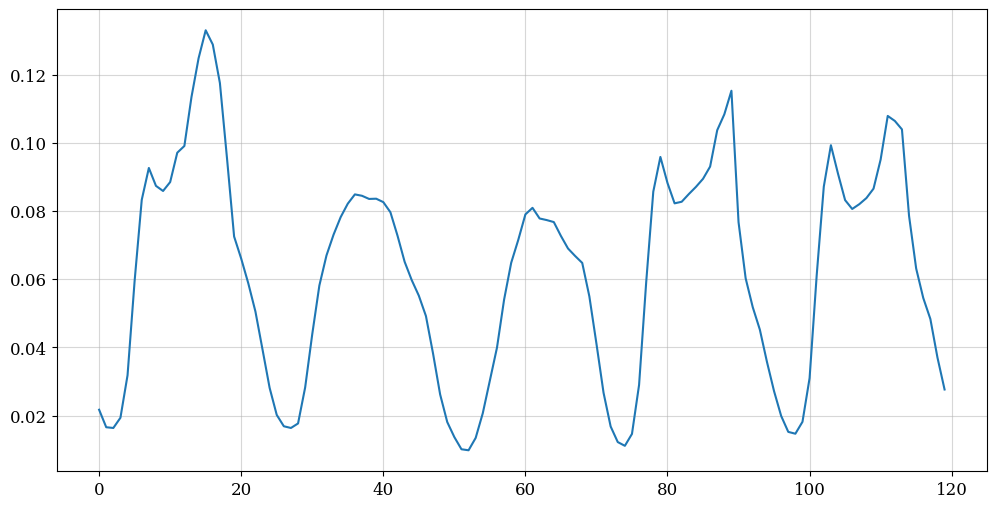

In [23]:
grouped["occupancy"][:24*5].plot();

In [24]:
COR_STEP = 12
pres = grouped[['flow', 'occupancy', 'speed']][0:-(COR_STEP)].reset_index(drop=True)
future = grouped[['flow', 'occupancy', 'speed']][COR_STEP:] \
    .reset_index(drop=True) \
    .add_suffix('_future')
val = pres.join(future)
val.corr()

,flow,occupancy,speed,flow_future,occupancy_future,speed_future
flow,1.000000,0.966218,-0.718619,-0.722547,-0.707590,0.701991
occupancy,0.966218,1.000000,-0.839110,-0.707282,-0.694619,0.686046
speed,-0.718619,-0.839110,1.000000,0.693508,0.681356,-0.599727
flow_future,-0.722547,-0.707282,0.693508,1.000000,0.966046,-0.718996
occupancy_future,-0.707590,-0.694619,0.681356,0.966046,1.000000,-0.839682
speed_future,0.701991,0.686046,-0.599727,-0.718996,-0.839682,1.000000


In [25]:
# creating 3-dimensional array for [timestep, timeframe, features]
def create_dataset(location, WINDOW_SIZE):
    
    # mask a certain location
    location_current = traffic[traffic["location"]==location].reset_index()
    
    # group to hour and average 12 (5-minute) timesteps
    location_current["hour"] = ((location_current["timestep"] - 1) // 12)
    grouped = location_current.groupby("hour").mean().reset_index()
    
    # add hour features as mod 24 cycle (0...23)
    grouped['day'] = (grouped['hour'] // 24) % 7
    grouped['hour'] %= 24
    
    one_hot_hour = pd.get_dummies(grouped['hour'])
    one_hot_hour = one_hot_hour.add_prefix('hour_')
    
    # merge all the features together to get a total of 27 features
    hour_grouped = pd.concat([grouped[["occupancy", "flow", "speed"]], one_hot_hour], axis=1)
    hour_grouped = np.array(hour_grouped)
    
    X, Y = [], []
    
    # add lag features (in reverse time order)
    for i in range(len(hour_grouped) - WINDOW_SIZE):
        X.append(hour_grouped[i:(i + WINDOW_SIZE)][::-1]) # reverse the order
        Y.append(hour_grouped[i + WINDOW_SIZE, 0]) # index 0 is occupy
    
    return X,Y # returns (timestep, timeframe, features) and (target)

In [26]:
### creating 4-th dimension for the locations
X, Y = [], []

for location in range(170):
    a,b = create_dataset(location, WINDOW_SIZE=24)
    X.append(a)
    Y.append(b)
    
X = np.moveaxis(X,0,-1)
Y = np.moveaxis(Y,0,-1)

print(X.shape)
print(Y.shape)

(1464, 24, 27, 170)
(1464, 170)


In [27]:
TRAIN_SIZE = 0.8
TEST_SIZE  = 0.2

train_size = int(len(X) * TRAIN_SIZE)
test_size  = int(len(X) * TEST_SIZE)

train_X, train_Y = X[:train_size], Y[:train_size]
test_X, test_Y = X[train_size:], Y[train_size:]

print(train_X.shape)
print(train_Y.shape)
print(test_X.shape)
print(test_Y.shape)

(1171, 24, 27, 170)
(1171, 170)
(293, 24, 27, 170)
(293, 170)


In [28]:
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()
train_X = scaler_X.fit_transform(train_X.reshape(train_X.shape[0] * train_X.shape[1], -1)) \
                   .reshape(train_X.shape[0], train_X.shape[1], -1)
test_X = scaler_X.transform(test_X.reshape(test_X.shape[0] * test_X.shape[1], -1)) \
                   .reshape(test_X.shape[0], test_X.shape[1], -1)
train_Y = scaler_Y.fit_transform(train_Y)
test_Y = scaler_Y.transform(test_Y)

In [29]:
print(train_X.shape)
print(test_X.shape)
print(train_Y.shape)
print(test_Y.shape)

(1171, 24, 4590)
(293, 24, 4590)
(1171, 170)
(293, 170)


In [30]:
# LSTM Model


model = Sequential([
    LSTM(256, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])),
    LSTM(256, return_sequences=False),
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(170, activation='linear'),
])

model.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])

# model = Sequential([
#     LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])),
#     LSTM(128, return_sequences=False),
#     Dropout(0.2),
#     Dense(128, activation='relu'),
#     Dropout(0.2),
#     Dense(170, activation='linear'),
# ])

# model.compile(loss='mse', optimizer='adam', metrics=[RootMeanSquaredError()])

I0000 00:00:1747316343.864497 3391064 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46653 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1747316343.864937 3391064 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 45436 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:41:00.0, compute capability: 8.9
/jahanxbProject/PyMIFE/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-05-15 08:39:04.529021: W external/local_xla/xla/service/gpu/llvm_gpu_backend/default/nvptx_libdevice_path.cc:40] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or 

UnknownError: {{function_node __wrapped__Sign_device_/job:localhost/replica:0/task:0/device:GPU:0}} JIT compilation failed. [Op:Sign] name: 

In [31]:
model.summary()

NameError: name 'model' is not defined